In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/feyzazkefe/trashnet/code")

Skipping, found downloaded files in "./trashnet" (use force=True to force download)


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
image_path = []
labels = []

for label in os.listdir("/content/trashnet/dataset-resized"):
    for img in os.listdir(f"/content/trashnet/dataset-resized/{label}"):
      image_path.append(f"/content/trashnet/dataset-resized/{label}/{img}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
1,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
2,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
3,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
4,/content/trashnet/dataset-resized/cardboard/ca...,cardboard


In [ ]:
data_df["labels"].value_counts()

,count
labels,
paper,594
glass,501
plastic,482
metal,410
cardboard,403
trash,137


In [ ]:
def plot_random_images(dataframe, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        random_row = dataframe.sample(n=1).iloc[0]
        img_path = random_row['image_path']
        label = random_row['labels']
        img = Image.open(img_path)

        print(img.size)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


(512, 384)
(512, 384)
(512, 384)
(512, 384)
(512, 384)


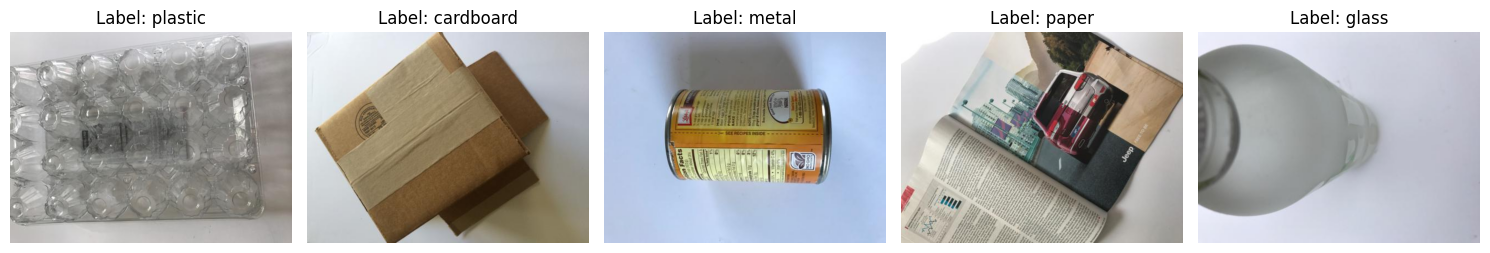

In [ ]:
plot_random_images(data_df)

In [ ]:
le = LabelEncoder()
data_df["labels_encoded"] = le.fit_transform(data_df["labels"])
data_df.head()

,image_path,labels,labels_encoded
0,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
1,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
2,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
3,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
4,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0


In [ ]:
class_names = le.classes_
print("Classes: ", class_names)

Classes:  ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


In [ ]:
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['labels_encoded'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels_encoded'], random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
class WasteDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe["labels_encoded"].values, dtype=torch.long)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]["image_path"]
        label = self.labels[index]

        image = Image.open(img_path)

        if image.mode in ('RGBA', 'LA') or (image.mode == 'P' and 'transparency' in image.info):
            alpha = image.convert('RGBA').split()[-1]
            bg = Image.new("RGB", image.size, (255, 255, 255))
            bg.paste(image, mask=alpha)
            image = bg
        else:
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = WasteDataset(train_df, transform_train)
val_dataset = WasteDataset(val_df, transform_val)
test_dataset = WasteDataset(test_df, transform_val)

In [ ]:
model = models.resnet50(weights='DEFAULT')

In [ ]:
# Congelando os pesos, não queremos treinar a rede toda, só a classificação final
for param in model.parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model.fc.in_features
num_ftrs

2048

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 6)
)

In [ ]:
model = model.to(device)

In [ ]:
train_labels = train_df['labels_encoded'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Ordem das Classes: {le.classes_}")
print(f"Pesos Calculados: {weights_tensor}")

Ordem das Classes: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
Pesos Calculados: tensor([1.0449, 0.8419, 1.0267, 0.7083, 0.8744, 3.0694], device='cuda:0')


In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('assets'):
    os.makedirs('assets')

In [ ]:
total_loss_train = []
total_acc_train = []
total_loss_val = []
total_acc_val = []

best_acc = 0.0
patience_counter = 0
PATIENCE = 5
EPOCHS = 25


for epoch in range(EPOCHS):
  train_loss = 0
  train_acc = 0
  model.train()

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

  for images, labels in loop:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * images.size(0) # Multiplica pelo tamanho do batch para média ponderada correta
    _, preds = torch.max(output, 1)
    train_acc += (preds == labels).sum().item()

    loop.set_postfix(loss=loss.item())

  model.eval()
  val_loss = 0
  val_correct = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)

      val_loss += loss.item() * images.size(0)
      _, preds = torch.max(output, 1)
      val_correct += (preds == labels).sum().item()

  avg_train_loss = train_loss / len(train_dataset)
  avg_train_acc = (train_acc / len(train_dataset)) * 100

  avg_val_loss = val_loss / len(val_dataset)
  avg_val_acc = (val_correct / len(val_dataset)) * 100

  total_loss_train.append(avg_train_loss)
  total_acc_train.append(avg_train_acc)
  total_loss_val.append(avg_val_loss)
  total_acc_val.append(avg_val_acc)

  if avg_val_acc > best_acc:
    best_acc = avg_val_acc
    patience_counter = 0
    torch.save(model.state_dict(), 'models/best_model.pth')
    print(f" -> Modelo Salvo! Nova Best Acc: {best_acc:.2f}%")
  else:
    patience_counter += 1
    if patience_counter >= PATIENCE:
      print("Early stopping triggered")
      break

  print(f" -> Train Acc: {avg_train_acc:.2f}% | Val Acc: {avg_val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")


Epoch 1/25: 100%|██████████| 56/56 [00:17<00:00,  3.19it/s, loss=0.595]


 -> Modelo Salvo! Nova Best Acc: 82.85%
 -> Train Acc: 67.25% | Val Acc: 82.85% | Val Loss: 0.5198


Epoch 2/25: 100%|██████████| 56/56 [00:11<00:00,  4.76it/s, loss=0.547]


 -> Modelo Salvo! Nova Best Acc: 86.81%
 -> Train Acc: 84.11% | Val Acc: 86.81% | Val Loss: 0.3897


Epoch 3/25: 100%|██████████| 56/56 [00:07<00:00,  7.31it/s, loss=0.38]


 -> Modelo Salvo! Nova Best Acc: 87.34%
 -> Train Acc: 89.65% | Val Acc: 87.34% | Val Loss: 0.3716


Epoch 4/25: 100%|██████████| 56/56 [00:08<00:00,  6.96it/s, loss=0.127]


 -> Train Acc: 91.01% | Val Acc: 87.07% | Val Loss: 0.4031


Epoch 5/25: 100%|██████████| 56/56 [00:08<00:00,  6.35it/s, loss=0.404]


 -> Modelo Salvo! Nova Best Acc: 89.97%
 -> Train Acc: 92.76% | Val Acc: 89.97% | Val Loss: 0.3405


Epoch 6/25: 100%|██████████| 56/56 [00:08<00:00,  6.57it/s, loss=0.34]


 -> Modelo Salvo! Nova Best Acc: 90.77%
 -> Train Acc: 95.31% | Val Acc: 90.77% | Val Loss: 0.2933


Epoch 7/25: 100%|██████████| 56/56 [00:08<00:00,  6.38it/s, loss=0.289]


 -> Train Acc: 94.68% | Val Acc: 90.50% | Val Loss: 0.3490


Epoch 8/25: 100%|██████████| 56/56 [00:07<00:00,  7.37it/s, loss=0.46]


 -> Train Acc: 95.76% | Val Acc: 89.71% | Val Loss: 0.3334


Epoch 9/25: 100%|██████████| 56/56 [00:07<00:00,  7.32it/s, loss=0.132]


 -> Train Acc: 96.38% | Val Acc: 89.45% | Val Loss: 0.3171


Epoch 10/25: 100%|██████████| 56/56 [00:09<00:00,  5.84it/s, loss=0.114]


 -> Train Acc: 97.23% | Val Acc: 89.71% | Val Loss: 0.3263


Epoch 11/25: 100%|██████████| 56/56 [00:08<00:00,  6.59it/s, loss=0.1]


Early stopping triggered


[[58  0  0  2  0  0]
 [ 0 69  3  0  4  0]
 [ 0  3 58  0  1  0]
 [ 3  1  1 79  0  5]
 [ 1  3  6  1 62  0]
 [ 0  0  0  0  1 19]]


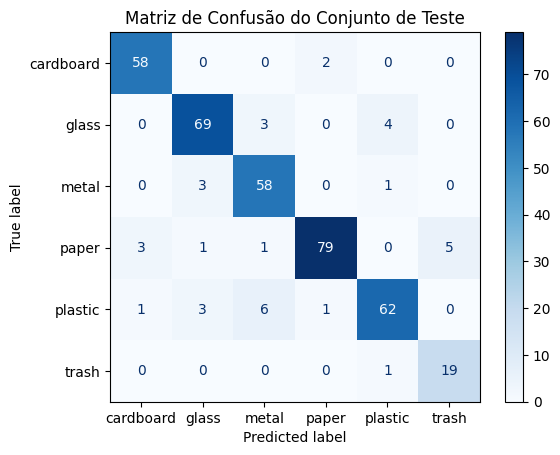

Acurácia Final no Teste: 90.79%


In [ ]:
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    _, preds = torch.max(output, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print(cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão do Conjunto de Teste')
plt.savefig('assets/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

final_test_acc = (np.array(all_preds) == np.array(all_labels)).sum() / len(test_dataset) * 100
print(f"Acurácia Final no Teste: {final_test_acc:.2f}%")

In [ ]:
def predict_waste(image_path, model, transform, class_names, device):
    model.eval()

    try:
        image = Image.open(image_path).convert('RGB')

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        image_tensor = transform(image).unsqueeze(0)
        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            outputs = model(image_tensor)

            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)

            predicted_label = class_names[predicted_idx.item()]
            conf_percent = confidence.item() * 100

        print(f"\n♻️ Classificação: **{predicted_label.upper()}**")
        print(f"📊 Confiança: {conf_percent:.2f}%")

        if conf_percent < 60:
            print("CUIDADO: O modelo está incerto. Talvez a imagem esteja fora do padrão.")

        return predicted_label

    except Exception as e:
        print(f"Erro ao processar imagem: {e}")

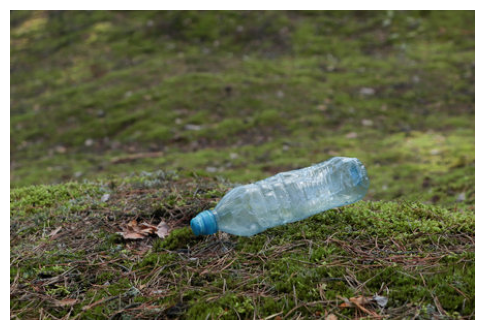


♻️ Classificação: **PLASTIC**
📊 Confiança: 62.18%


'plastic'

In [ ]:
predict_waste("assets/garrafa_de_plastico.jpg", model, val_loader.dataset.transform, class_names, device)

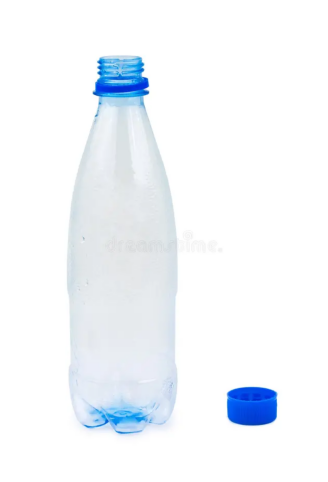


♻️ Classificação: **PLASTIC**
📊 Confiança: 99.79%


'plastic'

In [ ]:
predict_waste("assets/garrafa_de_plastico_fundo_branco.webp", model, val_loader.dataset.transform, class_names, device)

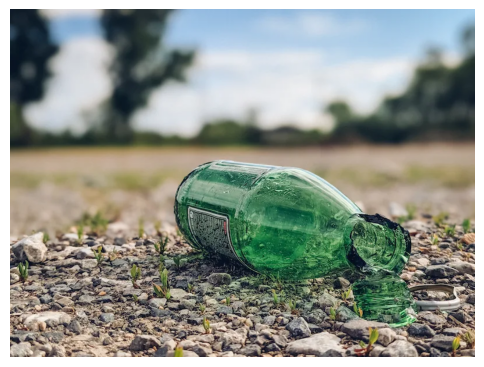


♻️ Classificação: **GLASS**
📊 Confiança: 81.93%


'glass'

In [ ]:
predict_waste("assets/garrafa_de_vidro.webp", model, val_loader.dataset.transform, class_names, device)

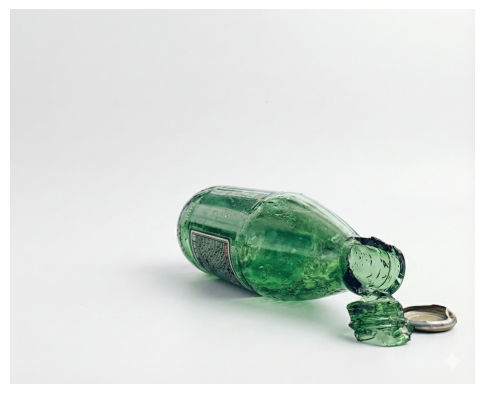


♻️ Classificação: **GLASS**
📊 Confiança: 98.46%


'glass'

In [ ]:
predict_waste("assets/garrafa_de_vidro_fundo_branco.png", model, val_loader.dataset.transform, class_names, device)